In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as ms
%matplotlib inline

In [2]:
train = pd.read_csv('ashrae-energy-prediction/train.csv')

In [3]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [4]:
test = pd.read_csv('ashrae-energy-prediction/test.csv')

In [5]:
test

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [6]:
### EDA Analysis

In [7]:
train.meter_reading.describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [8]:
#### Checking the time and date. Training data period and testing data period.

In [9]:
print(f'Training from {train.timestamp.min()} to {train.timestamp.max()} and predicting the test from {test.timestamp.min()} to {test.timestamp.max()}')

Training from 2016-01-01 00:00:00 to 2016-12-31 23:00:00 and predicting the test from 2017-01-01 00:00:00 to 2018-12-31 23:00:00


In [10]:
train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


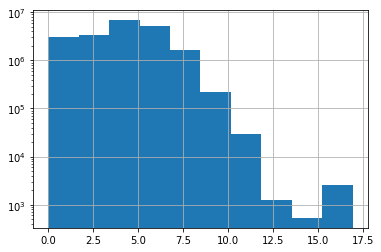

In [11]:
# target's log-log histogram:
ax = np.log1p(train.meter_reading).hist()
ax.set_yscale('log')

In [12]:
meters = train.groupby('building_id').meter.nunique()
# plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}')

Text(0.5, 1.0, 'Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}')

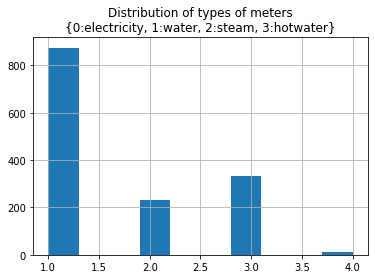

In [13]:
meters.hist()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [15]:
building_id = 1258
meters1 = train[train['building_id'] == building_id].meter.nunique()

In [16]:
new = train[train.building_id == 1258]
new.meter.unique()

array([0, 1, 2, 3], dtype=int64)

In [17]:
train[train.meter == train.meter.max()]

,building_id,meter,timestamp,meter_reading
105,106,3,2016-01-01 00:00:00,0.000
109,109,3,2016-01-01 00:00:00,0.000
113,112,3,2016-01-01 00:00:00,96.978
115,113,3,2016-01-01 00:00:00,19.597
117,114,3,2016-01-01 00:00:00,100.000
...,...,...,...,...
20215844,1322,3,2016-12-31 23:00:00,2476.610
20215847,1323,3,2016-12-31 23:00:00,1909.330
20215850,1324,3,2016-12-31 23:00:00,364.019
20215852,1325,3,2016-12-31 23:00:00,156.050


### Merging the weather data and the building meta data

In [18]:
building_data = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')

In [19]:
weather_data = pd.read_csv('ashrae-energy-prediction/weather_train.csv')

In [20]:

building_data.sample(3)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
219,2,219,Education,96124,1959.0,NaN
2,0,2,Education,5376,1991.0,NaN
1403,15,1403,Lodging/residential,78438,2004.0,NaN


In [21]:
train = train.merge(building_data, on='building_id', how= 'left')

In [22]:
train = train.merge(weather_data, on= ['timestamp', 'site_id'])

In [23]:
weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')

In [24]:
weather_test.sample(2)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
22458,1,2017-07-25 20:00:00,20.7,0.0,12.5,NaN,1013.1,170.0,3.1
173475,9,2018-12-23 12:00:00,10.6,0.0,1.7,0.0,1022.2,350.0,3.1


In [25]:
# test = test.merge(weather_test, on = ['timestamp'], how= 'left')

In [26]:
test = test.merge(building_data, on = 'building_id', how= 'left')

In [27]:
test.sample(10)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
8833145,8833145,405,0,2017-03-06 00:00:00,3,Education,82200,1916.0,NaN
30687111,30687111,1178,0,2018-06-17 05:00:00,13,Education,133072,NaN,NaN
37827559,37827559,1440,0,2017-04-17 09:00:00,15,Lodging/residential,150294,1987.0,NaN
15870735,15870735,718,0,2018-05-15 13:00:00,5,Education,25866,1919.0,2.0
35677826,35677826,1272,0,2018-05-25 22:00:00,14,Public services,247471,NaN,NaN
39015846,39015846,1336,0,2017-11-06 01:00:00,15,Office,31053,1915.0,NaN
12649397,12649397,399,0,2018-10-07 09:00:00,3,Education,180000,1939.0,NaN
30214822,30214822,1108,2,2018-04-14 13:00:00,13,Parking,679614,NaN,NaN
17767261,17767261,796,1,2017-01-29 03:00:00,7,Education,226042,1965.0,2.0
37071593,37071593,1322,3,2018-12-13 15:00:00,14,Entertainment/public assembly,166489,NaN,NaN


In [ ]:
new_test = test.merge(weather_test, on = ['site_id','timestamp'], how= 'left')

In [ ]:
# Saving the storage data
d_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}
for feature in d_types:
    train[feature] = train[feature].astype(d_types[feature])
    new_test[feature] = new_test[feature].astype(d_types[feature])
    
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

### Handling the missing Values in the train , test data

In [ ]:
train.isna().sum()

In [ ]:
import missingno as sn

In [ ]:
sn.matrix(train)